**Regression discontinuity example: Banking Recovery data**

After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off".  

But that doesn't mean the bank simply walks away from the debt.  They still want to collect some of the debt.  

The bank will score the account to assess the expected recovery amount, that is the expected amount that the bank may be able to receive from the customer in the future (fixed time period such as one year).  This amount is a function of the probability of the customer paying, the total debt and other factors that impact the ability and willingness to pay.

The bank has implemented different recovery strategies at different thresholds (\$1000, \$2000, etc.) where the greater the expected recovery amount the more effort the bank puts into contacting the customer.  For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system.  For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to contact the customer and obtian payments.

A key question is whether the recovery strategy's extra efforts result in greater recovered amounts.  Each additional level of recovery strategy requires an additional \$50 per customer so that customers in the Recovery Strategy Level 1 cost the company \$50 more than those in Level 0.  Those in Level 2 cost \$50 more than those in Level 1, etc.

Since this assignment to recovery strategy is done administratively (and not as a randomized A/B test) we need to employ different methods to assess the impact of the recovery strategy.  The analysis needed to estimate the impact is retrospective and not prospective.

We will focus not on the entire range of the expected recovery amount but only on a small range just above and below the threshold used for assignment.

Key things we want to determine are:
- Did other variables (not used for the assignment) vary continuously across the thresholds?  In this case, we have data about the customer's age and sex.
- After controlling for the variable used for assignment (expected_recovery_amount) was the actual recovery amount greater at higher Recovery level?
- Did the extra Recovery amount exceed the extra costs? (or, in other words, should the company pay \$50 more per customer to make the extra effort needed at the higher level?)

Import necessary libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model
from IPython.display import Image

Importing bank data

In [8]:
bank_data= '~/Desktop/bank_data.csv'
df = pd.read_csv(bank_data)

Printing first few rows of df

In [9]:
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


**Describe the data set**

It includes a customer id (identification), Expected Recovery Amount (used for assigning the customer to different recovery strategies), Actual recovery amount, Age, Sex, and Recovery Strategy Level

In [10]:
df.describe()

,id,expected_recovery_amount,actual_recovery_amount,age
count,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372
std,591.458429,2019.826565,4576.506350,15.453072
min,6.000000,194.000000,200.425000,18.000000
25%,534.250000,1261.250000,1045.190300,28.000000
50%,1029.500000,2062.000000,2115.446373,35.000000
75%,1551.750000,3569.500000,5417.237207,50.000000
max,2056.000000,9964.000000,34398.479710,84.000000


Check the variable types:
    Sex should be set to categorical variables

In [11]:
df.dtypes

id                            int64
expected_recovery_amount      int64
actual_recovery_amount      float64
recovery_strategy            object
age                           int64
sex                          object
dtype: object

If sex is set to an object variable, change it to a category using astype

In [12]:
df["sex"] = df["sex"].astype('category')
df.dtypes

id                             int64
expected_recovery_amount       int64
actual_recovery_amount       float64
recovery_strategy             object
age                            int64
sex                         category
dtype: object

The Recovery Strategy was assigned based on the expected recovery amount.  Can you tell what the thresholds were?

In [13]:
grouped_data = df.groupby(['recovery_strategy'])
grouped_data['expected_recovery_amount'].describe().unstack()

,count,mean,std,min,25%,50%,75%,max
recovery_strategy,,,,,,,,
Level 0 Recovery,247.0,825.372470,132.168218,194.0,741.50,848.0,939.00,1000.0
Level 1 Recovery,670.0,1442.071642,284.890388,1001.0,1190.00,1416.0,1683.50,1997.0
Level 2 Recovery,333.0,2455.171171,288.826548,2001.0,2211.00,2435.0,2705.00,2992.0
Level 3 Recovery,368.0,3797.497283,571.032441,3002.0,3323.25,3702.5,4188.75,4987.0
Level 4 Recovery,264.0,6852.852273,1419.983625,5008.0,5538.75,6605.0,7931.00,9964.0


Examining the distribution of Expected Recovery Amount

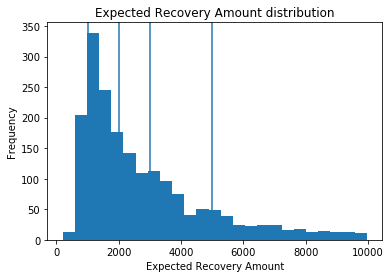

In [14]:
plt.hist(df['expected_recovery_amount'], bins=25)
plt.title("Expected Recovery Amount distribution")
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Frequency")
plt.axvline(x=1000)
plt.axvline(x=2000)
plt.axvline(x=3000)
plt.axvline(x=5000)
plt.show()
%matplotlib inline

Zeroing in on the first transition (between Level 0 and Level 1) means we are focused on the population 
with expected recovery amounts between \$0 and \$2000 where the transition between Levels occurred at \$1000.

We know the customers in Level 1 (expected recovery amounts >1000) received more attention from the bank 
and, by definition, that they had higher expected recovery amounts than the customers in Level \$0.


A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically
across the \$1000 threshold.  

For example, does the percent of customers that are female show a jump (discontinuity) at the \$1000 threshold or does that percent move fairly smoothly? 

Does the customer age show a jump (discontinuity) at the \$1000 threshold or does that age vary smoothly?

Start by first plotting the age as a function of Expected Recovery Amount

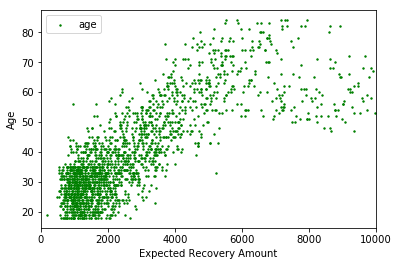

In [15]:
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="g", s=2)
plt.xlim(0, 10000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.legend(loc=2)
plt.show()

Now plot age as a function of Expected Recovery Amount for a smaller window of Expected Recovery Amount, \$0-\$2000.  This range covers Levels 0 and 1  

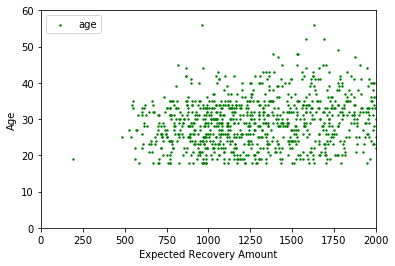

In [16]:
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="g", s=2)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.legend(loc=2)
plt.show()

Compute the average age just above and just below the \$1000 threshold.  Determine if there is a difference in these ages.

For determining if there is a difference in the ages, we will use the Kruskall Wallis test which is a robust test (does not make distributional assumptions).  You can also use the t-test which specifically makes assumptions about the distribution of the variables.

In [19]:
grouped_data = df.loc[(df['expected_recovery_amount']<2000) & (df['expected_recovery_amount']>=0)].groupby(['recovery_strategy'])
grouped_data['age', 'expected_recovery_amount','actual_recovery_amount'].describe().unstack()

age                                                     \
                   count       mean       std   min   25%   50%   75%   max   
recovery_strategy                                                             
Level 0 Recovery   247.0  27.627530  5.975469  18.0  23.0  27.0  32.0  56.0   
Level 1 Recovery   670.0  29.773134  6.904594  18.0  24.0  30.0  34.0  56.0   

                  expected_recovery_amount                  ...               \
                                     count         mean     ...          75%   
recovery_strategy                                           ...                
Level 0 Recovery                     247.0   825.372470     ...        939.0   
Level 1 Recovery                     670.0  1442.071642     ...       1683.5   

                          actual_recovery_amount                           \
                      max                  count         mean         std   
recovery_strategy                                                           
Level 0 Recovery   1000.0                  247.0   521.027126  205.609793   
Level 1 Recovery   1997.0                  670.0  1301.689329  488.180769   

                                                                    \
                          min         25%         50%          75%   
recovery_strategy                                                    
Level 0 Recovery   200.425000  370.717500   500.23000   616.805000   
Level 1 Recovery   433.199166  974.591776  1196.26044  1551.723081   

                                
                           max  
recovery_strategy               
Level 0 Recovery   1300.790000  
Level 1 Recovery   5018.282398  

[2 rows x 24 columns]

When we look at the entire range of Level 0 and Level 1, we see a very large difference in the actual recovery amount of around \$781 (=\$1302-\$521) between the Level 1 and Level 0 groups.  

**What is the difference in the actual recovery amount when we observe when we use a narrower range such as \$750 to \$1250 or the range of \$900 to \$1100?**  

For the range of \$900 to \$1100 you should see a difference of about \$333 between the two recovery levels (and a similar amount for the range of \$950 to \$1050)

In [20]:
Level_0_age = df.loc[(df['expected_recovery_amount']<2000) & (df['expected_recovery_amount']>=0) & (df['recovery_strategy']=="Level 0 Recovery")]['age']
Level_1_age = df.loc[(df['expected_recovery_amount']<2000) & (df['expected_recovery_amount']>=0) & (df['recovery_strategy']=="Level 1 Recovery")]['age']
stats.kruskal(Level_0_age,Level_1_age) 

KruskalResult(statistic=17.74265377474401, pvalue=2.5289215640638461e-05)

In [21]:
stats.ttest_ind(Level_0_age,Level_1_age)

Ttest_indResult(statistic=-4.3230029505214711, pvalue=1.7080035245137415e-05)

Chi-square tests of %male vs %female

In [22]:
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<2000) & (df['expected_recovery_amount']>=0)]['recovery_strategy'], df['sex'])
crosstab


sex,Female,Male
recovery_strategy,,
Level 0 Recovery,108,139
Level 1 Recovery,316,354


In [23]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
p_val

0.39416505436866123

We can see that when examining the entire range of the Expected Recovery Amount for Levels 0 and 1 (\$0 to \$2000), there is no significant difference in the distribution of sex but there is a significant difference in the distribution of age.

Using subjects near the cutoff enables one to compare customers from Recovery Level 0 and Recovery Level 1 who are likely to be similar, but assignment to the Levels. 

**What happens when we choose a narrower range like \$750 to \$1250 or an even narrower range like \$900 to \$1100?**


In [24]:
df['indicator_900'] = np.where(df['expected_recovery_amount']<900, 0, 1)
df['indicator_950'] = np.where(df['expected_recovery_amount']<950, 0, 1)
df['indicator_975'] = np.where(df['expected_recovery_amount']<975, 0, 1)
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)
df['indicator_1025'] = np.where(df['expected_recovery_amount']<1025, 0, 1)
df['indicator_1050'] = np.where(df['expected_recovery_amount']<1050, 0, 1)
df['indicator_1075'] = np.where(df['expected_recovery_amount']<1075, 0, 1)
df['indicator_1100'] = np.where(df['expected_recovery_amount']<1100, 0, 1)
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex,indicator_900,indicator_950,indicator_975,indicator_1000,indicator_1025,indicator_1050,indicator_1075,indicator_1100
0,2030,194,263.540,Level 0 Recovery,19,Male,0,0,0,0,0,0,0,0
1,1150,486,416.090,Level 0 Recovery,25,Female,0,0,0,0,0,0,0,0
2,380,527,429.350,Level 0 Recovery,27,Male,0,0,0,0,0,0,0,0
3,1838,536,296.990,Level 0 Recovery,25,Male,0,0,0,0,0,0,0,0
4,1995,541,346.385,Level 0 Recovery,34,Male,0,0,0,0,0,0,0,0


In [25]:
df.describe()

,id,expected_recovery_amount,actual_recovery_amount,age,indicator_900,indicator_950,indicator_975,indicator_1000,indicator_1025,indicator_1050,indicator_1075,indicator_1100
count,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372,0.916047,0.897981,0.886291,0.869288,0.859192,0.845377,0.832625,0.818810
std,591.458429,2019.826565,4576.506350,15.453072,0.277391,0.302754,0.317542,0.337175,0.347915,0.361641,0.373410,0.385278
min,6.000000,194.000000,200.425000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,534.250000,1261.250000,1045.190300,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1029.500000,2062.000000,2115.446373,35.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1551.750000,3569.500000,5417.237207,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2056.000000,9964.000000,34398.479710,84.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


If there was no impact of the program on the actual recovery amount, then we would expect that the relationship between the expected recovery amount and the actual recovery amount would be continuous. 

If there was some impact of the program on the actual recovery amount, then we would expect that, after controlling for the expected recovery amount, there would still be some "jump" or "discontinuity" at the threshold where the program begins.  

The size of the discontinuity is the impact of the program at that threshold.  We want to determine if the size of the impact is greater than the cost of the program (\$50 per person)


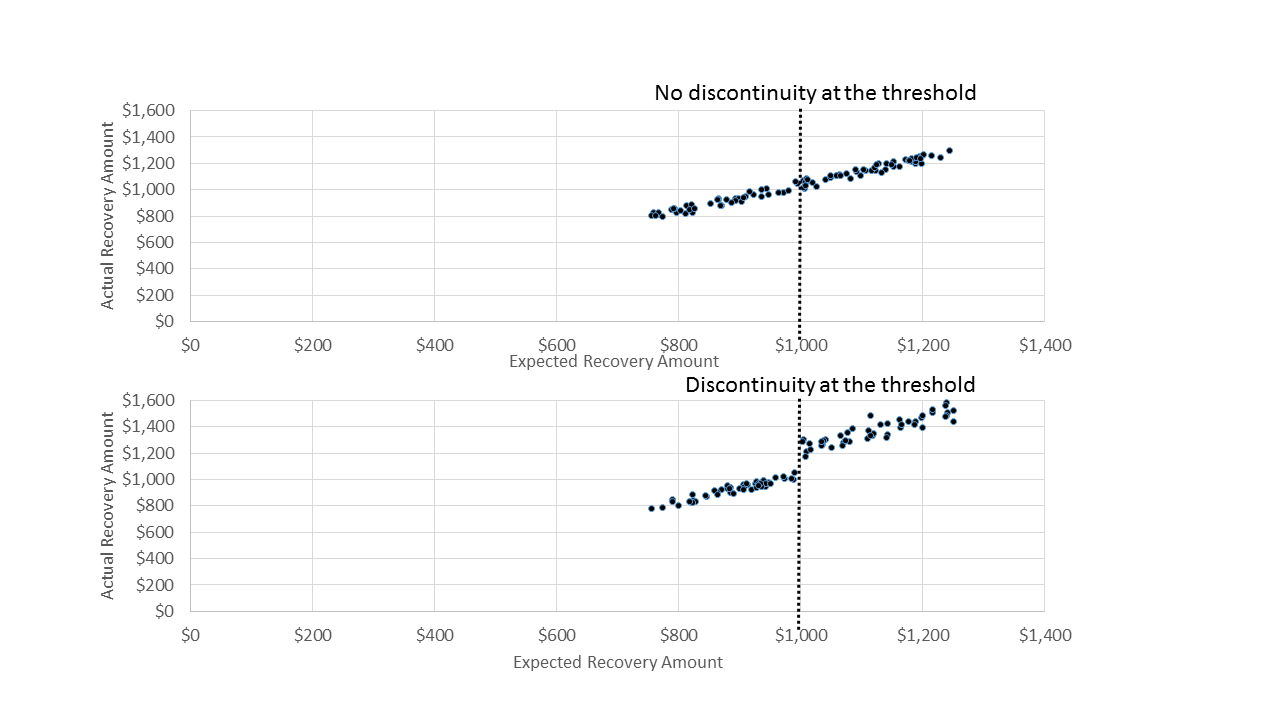

In [26]:
from IPython.display import Image
Image(filename='Regression Discontinuity graph.png')

Develop a regression model of actual recovery amount as a function of expected recovery amount.

Later we will explore the impact of adding to this regression model the threshold indicator for the "fake" thresholds of \$900, \$925, \$950, \$975, \$1025, \$1050, \$1075, and \$1100 as well as the impact of adding the true threshold of \$1000.  

If there is an impact of the program, then we expect that the true threshold of \$1000 will not only be the best model (as measured by adjusted R-squared) but also that the regression coefficient of the indicator_1000 is the estimate of the impact of the program.  Also, the regression coefficient should be similar to the difference we say in the average recovery amount just above and just below the threshold which we saw earlier was about \$300

To start, let's build this model for customers in the range between \$750 and \$1250 using just expected recovery amount as an independent variable and actual recovery amount as the dependent variable

In [27]:
# define the data/predictors as the pre-set feature names  
x = df.loc[(df['expected_recovery_amount']<1250) & (df['expected_recovery_amount']>750)]['expected_recovery_amount']
y = df.loc[(df['expected_recovery_amount']<1250) & (df['expected_recovery_amount']>750)]['actual_recovery_amount']
x = sm.add_constant(x)

In [28]:
model = sm.OLS(y, x).fit()
predictions = model.predict(x)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.416
Model:                                OLS   Adj. R-squared:                  0.415
Method:                     Least Squares   F-statistic:                     279.6
Date:                    Thu, 30 Aug 2018   Prob (F-statistic):           9.18e-48
Time:                            10:15:44   Log-Likelihood:                -2751.5
No. Observations:                     394   AIC:                             5507.
Df Residuals:                         392   BIC:                             5515.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
const                     -832.7972     98.549     -8.451      0.000     -1026.548  -639.047
expected_recovery_amount     1.6123      0.096     16.722      0.000         1.423     1.802
==============================================================================
Omnibus:                      108.623   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.953
Skew:                           1.267   Prob(JB):                     1.66e-71
Kurtosis:                       6.665   Cond. No.                     7.64e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here we can see that expected recovery amount is OK at predicting actual recovery amount, with an adjusted R-squared of 0.415.  As we saw from the graph, on average the actual_recovery_amount increases as the expected_recovery_amount increases.  We could add polynomial terms of expected recovery amount to the model but, for the purposes of this practice, let's stick with using just the linear term.

Adding in the variable that indicates the Recovery Level results in an even better model where the regression coefficient for the Recovery Level is the estimate of the impact of the program.

In [29]:
indicator_1000 = df.loc[(df['expected_recovery_amount']<1250) & (df['expected_recovery_amount']>750)]['indicator_1000']

In [30]:
# define the data/predictors as the pre-set feature names  
X = df.loc[(df['expected_recovery_amount']<1250) & (df['expected_recovery_amount']>750),['expected_recovery_amount','indicator_1000']]
y = df.loc[(df['expected_recovery_amount']<1250) & (df['expected_recovery_amount']>750)]['actual_recovery_amount']
X = sm.add_constant(X)

In [31]:
model = sm.OLS(y,X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.455
Model:                                OLS   Adj. R-squared:                  0.452
Method:                     Least Squares   F-statistic:                     163.2
Date:                    Thu, 30 Aug 2018   Prob (F-statistic):           2.96e-52
Time:                            10:17:08   Log-Likelihood:                -2738.0
No. Observations:                     394   AIC:                             5482.
Df Residuals:                         391   BIC:                             5494.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
const                     -185.6941    155.560     -1.194      0.233      -491.534   120.145
expected_recovery_amount     0.8393      0.174      4.825      0.000         0.497     1.181
indicator_1000             251.2557     47.723      5.265      0.000       157.429   345.082
==============================================================================
Omnibus:                      108.482   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.687
Skew:                           1.296   Prob(JB):                     1.87e-66
Kurtosis:                       6.423   Cond. No.                     1.28e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression coefficient for this model is \$251 with a standard error of \$48 and the variable for indicator_1000 is statistically significant (P<0.001) while the adjusted R-squared has increased to 0.455.  

**How does this regression coefficient compare to the descriptive statistics difference when you used a smaller range such as \$900 to \$1100 or the range \$950 to \$1050?**

In [32]:
# define the data/predictors as the pre-set feature names  
X = df.loc[(df['expected_recovery_amount']<1100) & (df['expected_recovery_amount']>900),['expected_recovery_amount','indicator_1000']]
y = df.loc[(df['expected_recovery_amount']<1100) & (df['expected_recovery_amount']>900)]['actual_recovery_amount']
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.306
Model:                                OLS   Adj. R-squared:                  0.298
Method:                     Least Squares   F-statistic:                     39.05
Date:                    Thu, 30 Aug 2018   Prob (F-statistic):           8.95e-15
Time:                            10:17:35   Log-Likelihood:                -1252.6
No. Observations:                     180   AIC:                             2511.
Df Residuals:                         177   BIC:                             2521.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
const                       61.5437    653.172      0.094      0.925     -1227.463  1350.550
expected_recovery_amount     0.5840      0.682      0.856      0.393        -0.762     1.930
indicator_1000             281.5309     75.477      3.730      0.000       132.580   430.482
==============================================================================
Omnibus:                       63.949   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.962
Skew:                           1.494   Prob(JB):                     6.17e-39
Kurtosis:                       6.813   Cond. No.                     3.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

You should observe that using a narrower range results in a consistent estimate of the regression coefficient.

We know that the true threshold is \$1000.  If we use a "false threshold" like \$900, \$950, \$1050 or \$1100, we expect that the regression model should be a worse fit (as measured by adjusted R-squared) and the estimated regression coefficient for the threshold will be less than the actual impact.

Recall that when we built the model using a range of expected recovery amount of \$750 to \$1250, regression coefficient for this model is \$251 with a standard error of \$48 and the variable for indicator_1000 was statistically significant (P<0.001) while the adjusted R-squared was 0.455.

**Using the range of \$750 to \$1250, what do you observe when you use a "false threshold" of \$900? \$950? \$1050? \$1100?** 

You should conclude that the model is best (highest adjusted R-squared) when you use the true threshold of \$1000, the regression coefficient is statistically significant and the regression coefficient (\$251) is much larger than the incremental cost of \$50 per customer.

**Further exploration**

We did this work for the threshold between Level 0 and Level 1 which occurs at \$1000.

What happens when you do this exploration for Level 1 to 2?  Is the incremental impact of Level 2 worth the costs?